In [ ]:
import torch 
import torch.nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from Trainer import Trainer

from variational_probing import VariationalProbingModel, RegularProbingModel
from utils import *

import numpy as np

from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import json

%matplotlib inline

In [2]:
data_path_train = "conll2000_train.txt"
data_path_val = "conll2000_test.txt"


train_dataset = MDLDataset_POSTagging(data_path_train)
tagging_tokenizer = train_dataset.tagging_tokenizer
val_dataset = MDLDataset_POSTagging(data_path_val, tagging_tokenizer)

model = VariationalProbingModel(pretrained_path="D:/models/roberta-base", out_features=len(tagging_tokenizer)).to("cuda")
model_non_var = RegularProbingModel(pretrained_path="D:/models/roberta-base", out_features=len(tagging_tokenizer)).to("cuda")

tokenizer = AutoTokenizer.from_pretrained("D:/models/roberta-base")

collator = Collator(
    tokenizer=tokenizer,
    post_tagging_tokenizer=tagging_tokenizer,
    max_length=1024,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

BATCH_SIZE = 1024

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)


[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     C:\Users\Nikita\AppData\Roaming\nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
Some weights of RobertaModel were not initialized from the model checkpoint at D:/models/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at D:/models/roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint 

In [3]:
trainer_non_var = Trainer(
    model=model_non_var, 
    train_config={
        "variational": False, 
        "eval_metrics": ["cross_entropy_loss", "accuracy"],
        "lr": 1e-3,
        "optimizer": "Adam",
        "n_epochs": 500,
        "loss_function": "crossentropy",
        "ignore_index": tagging_tokenizer.pad_token_id
    }
)


model_non_var = trainer_non_var.train(
    train_loader=train_loader,
    val_loader=val_loader,
    evaluate_every=1,
    KL_weight=None
)

val_metrics_non_var = trainer_non_var._metrics

training epoch:   0%|          | 0/500 [00:00<?, ?it/s]

In [4]:
torch.save(model_non_var, "non_variational_roberta_demo.pt")

In [5]:
trainer = Trainer(
    model=model, 
    train_config={
        "variational": True, 
        "eval_metrics": ["description_length", "accuracy"],
        "lr": 1e-3,
        "optimizer": "Adam",
        "n_epochs": 500,
        "loss_function": "crossentropy",
        "ignore_index": tagging_tokenizer.pad_token_id
    }
)


model = trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    evaluate_every=1,
    KL_weight=0.001
)

val_metrics = trainer._metrics

training epoch:   0%|          | 0/500 [00:00<?, ?it/s]

In [6]:
torch.save(model, "variational_roberta_demo.pt")

In [8]:
val_metrics[0], val_metrics_non_var[0]

({'cross_entropy_loss': 92813.36,
  'KL_divergence': 151730.48,
  'description_length': 244543.84,
  'accuracy': 0.05307349},
 {'cross_entropy_loss': 91711.68, 'accuracy': 0.09376837})

In [ ]:
# Uncomment to save metrics

# for i in range(len(val_metrics)):
#     val_metrics[i] = {k: float(v) for k, v in val_metrics[i].items()}
# for i in range(len(val_metrics_non_var)):
#     val_metrics_non_var[i] = {k: float(v) for k, v in val_metrics_non_var[i].items()}

# with open("variational_val_metrics.json", "w", encoding="utf-8") as f:
#     json.dump(val_metrics, f, indent=4)

# with open("non_variational_val_metrics.json", "w", encoding="utf-8") as f:
#     json.dump(val_metrics_non_var, f, indent=4)

In [ ]:
# Uncomment to load precalculated metrics

# with open("variational_val_metrics.json", "r", encoding="utf-8") as f:
#     val_metrics = json.load(f)
# with open("non_variational_val_metrics.json", "r", encoding="utf-8") as f:
#     val_metrics_non_var = json.load(f)

In [57]:
def visualize(
    metrics,
    *args, 
    legend_labels=["MDL", "Train"],
    show_only_these=None,
    Epoch_step=10
): 
    all_metrics_lists = [metrics, *args]
    all_metrics_labels = set.union(*[set(elem[0].keys()) for elem in all_metrics_lists])

    if show_only_these is None:
        metrics_to_show = list(all_metrics_labels)
    else:
        metrics_to_show = list(all_metrics_labels & set(show_only_these))

    n_metrics = len(metrics_to_show)
    
    fig, axes = plt.subplots(n_metrics, 1, figsize=(12, n_metrics * 6))
    fig.subplots_adjust(wspace=0, hspace=0.3)

    x_axis = np.arange(len([elem[list(elem.keys())[0]] for elem in all_metrics_lists[0]])) * Epoch_step + Epoch_step

    for i in range(n_metrics):
        for j in range(len(all_metrics_lists)):
            if metrics_to_show[i] in all_metrics_lists[j][0]:
                axes[i].plot(x_axis, [elem[metrics_to_show[i]] for elem in all_metrics_lists[j]], label=legend_labels[j])

        axes[i].set_title(metrics_to_show[i], fontsize=20)
        axes[i].legend(shadow=True, fontsize=18)
        axes[i].set_xlabel("Epochs", fontsize=16)

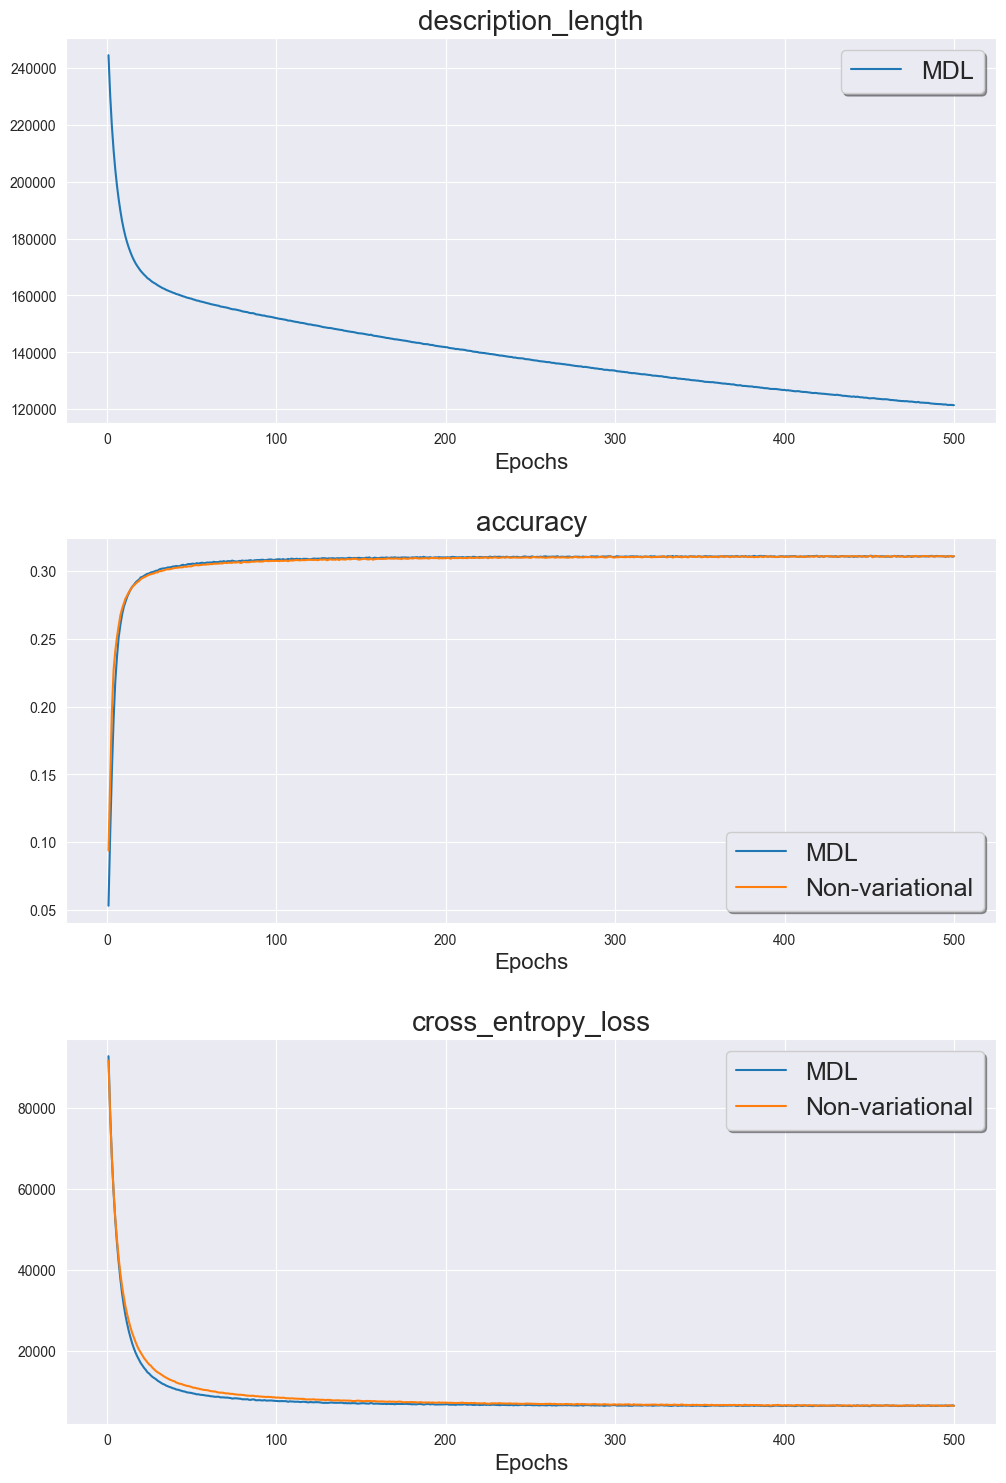

In [58]:
visualize(
    val_metrics, 
    val_metrics_non_var,
    legend_labels=["MDL", "Non-variational"], 
    show_only_these=["accuracy", "description_length", "cross_entropy_loss"],
    Epoch_step=1
)